# ARIMA

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot
from matplotlib.pylab import rcParams

In [24]:
rcParams['figure.figsize'] = 15, 6

In [25]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


The data contains a particular month and number of passengers traveling in that month. In order to read teh data as a time series, we have to pass special arguments to the read_csv() method.

In [ ]:
# dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
# df = pd.read_csv('../data_sets/AirPassengers.csv', parse_dates=['Month'], index_col='Month', date_parser=dateparse)

df = pd.read_csv(
    '../data_sets/AirPassengers.csv',
    parse_dates=['Month'],
    index_col='Month'
)

In [31]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [32]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[us]', name='Month', length=144, freq=None)

In [33]:
# Convert to time series
ts = df['#Passengers']
ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [34]:
ts['1949-01-01']

np.int64(112)

In [35]:
from datetime import datetime
ts[datetime(1949,1,1)]

np.int64(112)

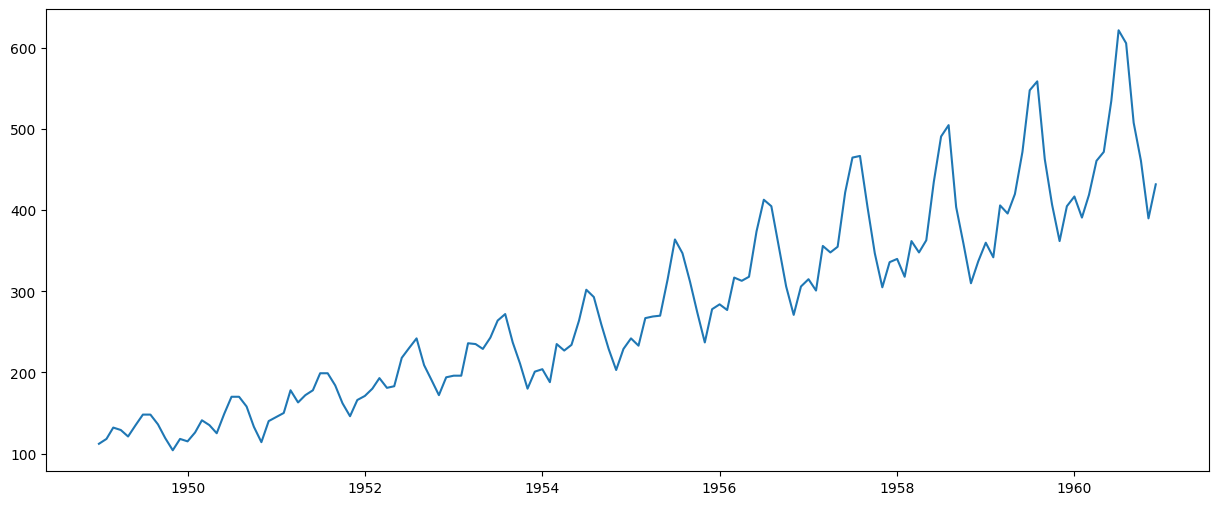

In [ ]:
# Check Stationarity manually first
plt.plot(ts)

## Stationality Test (ADF)